# Sinusoidal model: Augment by 0/1 (epoch 25) vs. Time labels

Reason: In epoch 25, the network trained with the encoding "Augment by 0/1" reaches approximately the same loss as the network trained with "Time labels" in the final epoch. We want to compare the estimated posteriors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm, gaussian_kde
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [4]:
# Dataset 1 (n_missing = 15)
param_prior_1 = np.array([[0.2, -0.4]])
result_1 = [
    np.array(
        [
            -0.38822525, -0.07585579,  0.09875853,  0.42901483,  0.48185913,
             0.62969871,  0.6457469 ,  0.434365  ,  0.20191629, -0.12380711,
            -0.41445603, -0.71438838, -1.10485856, -1.23079156, -1.36338658,
            -1.44566409, -1.45376767, -1.25233028, -0.98761422, -0.76457333,
            -0.41138701, -0.06165886,  0.19041922,  0.33472721,  0.54920351,
             0.63987353,  0.52822556,  0.4772211 ,  0.0992428 , -0.08048652,
            -0.37974125, -0.6531358 , -1.05218318, -1.23381172, -1.34811474,
            -1.42620643, -1.39496478, -1.15792385, -0.91626909, -0.72581709,
            -0.34380109,
        ]
    ),
    np.array(
        [
            0,  1,  2,  3,  4,  5,  6,  9, 11, 13, 14, 16, 17, 19, 20, 24, 25,
            27, 28, 29, 30, 31, 33, 36, 37, 39,
        ]
    ),
     np.array(
         [
             0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.25, 2.75, 3.25, 3.5 ,
             4.  , 4.25, 4.75, 5.  , 6.  , 6.25,
             6.75, 7.  , 7.25, 7.5 , 7.75,
             8.25, 9.  , 9.25, 9.75,
         ],
     ),
]

# Dataset 2 (n_missing = 20)
param_prior_2 = np.array([[0.95, 0.1]])
result_2 = [
    np.array(
        [
             0.0411556 ,  1.08346297,  0.2623786 , -0.92034164, -0.17167728,
             1.02610335,  0.54370587, -0.78445069, -0.52135847,  0.85621658,
             0.77392383, -0.61739495, -0.73033272,  0.55306994,  1.02138007,
            -0.28863467, -0.77016348,  0.38925967,  1.03721564,  0.0408748 ,
            -0.91261586, -0.00819852,  1.12443804,  0.37746972, -0.84010395,
            -0.32655636,  0.99065733,  0.55809712, -0.67683952, -0.53908892,
             0.76198376,  0.88392371, -0.56456167, -0.77304082,  0.58618039,
             0.99736459, -0.13568713, -0.96373333,  0.26542047,  1.05570096,
             0.07219064,
        ]
    ),
    np.array(
        [
            1,  4,  5,  7,  9, 12, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 32,
            33, 36, 37, 38,
        ],
    ),
    np.array(
        [
            0.25, 1.  , 1.25, 1.75, 2.25, 3.  , 3.5 , 3.75, 4.  , 4.75, 5.25,
            5.5 , 6.  , 6.5 , 6.75, 7.  , 8.  , 8.25, 9.  , 9.25, 9.5,
        ],
    ),
]

param_priors = [param_prior_1, param_prior_2]
results = [result_1, result_2]

In [5]:
n_post_samples = 7500

# Augment by 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_augment01 = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_augment01,
    checkpoint_path='./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts', 
    skip_checks=True,
)

# Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_timelabels = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_timelabels,
    checkpoint_path='./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts', 
    skip_checks=True,
)

amortizers = {"augment01": amortizer_augment01, "timelabels": amortizer_timelabels}

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-25
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


In [6]:
# Augment by 0/1: loss in epoch 25
np.mean([-9.55491, -9.830762, -9.599989, -10.095994, -10.0241785, -9.889624, -10.160992, -9.964481, -9.833771, -9.869265, -10.01029, -10.054309, -9.974884, -9.845129, -10.012761, -9.853227, -9.889691, -10.019358, -10.011637, -9.810125, -9.789429, -10.122795, -10.184776, -9.881031, -9.942009, -10.01664, -10.1158905, -10.0348835, -10.151241, -9.842237, -10.081087, -10.215372, -10.028932, -9.967049, -10.169952, -10.1073265, -10.098747, -9.9638195, -9.709223, -10.193285, -9.780987, -10.107448, -9.872709, -10.107491, -10.110785, -10.209187, -10.182247, -10.151148, -10.234737, -9.982693, -9.918366, -10.222916, -10.077166, -10.036121, -10.221313, -9.848442, -10.009249, -10.078307, -9.874039, -10.030924, -9.966314, -10.083048, -10.302427, -10.04412, -10.253019, -9.693489, -9.792137, -10.274316, -9.811676, -9.86778, -10.108887, -9.958288, -10.089261, -9.867925, -9.586434, -9.944606, -9.225315, -9.4264145, -9.761559, -9.842527, -9.80356, -10.023249, -10.093027, -10.047822, -9.772568, -9.973747, -10.1466465, -9.776011, -9.807323, -9.716806, -9.837038, -9.551374, -9.5229, -10.088482, -9.888749, -9.690511, -9.737293, -9.866411, -9.825647, -9.951027, -9.619289, -9.58452, -10.038744, -9.7396145, -10.009786, -9.805289, -9.76165, -9.804462, -9.526701, -9.714658, -10.03659, -9.99642, -10.106036, -9.903649, -9.884589, -9.929925, -10.020054, -9.875773, -9.759129, -9.809776, -9.732149, -9.816955, -9.92501, -10.057817, -10.062845, -10.073378, -9.75233, -10.048527, -9.949821, -9.981044, -10.063182, -9.925945, -10.162981, -10.127919, -9.85668, -10.114845, -10.191103, -9.98256, -10.208885, -9.983625, -10.153598, -10.052687, -10.088257, -10.072889, -9.899683, -10.246597, -10.136293, -10.044525, -9.962427, -10.082983, -10.34053, -10.175007, -10.127691, -10.270245, -10.197313, -10.146733, -10.255945, -10.088722, -10.242474, -10.113696, -9.888197, -10.315823, -9.994772, -10.135374, -10.072433, -9.9828205, -9.916634, -9.888113, -9.848656, -9.626896, -9.945921, -9.841668, -9.290497, -8.650445, -9.529516, -9.89366, -9.550524, -9.634698, -9.917136, -9.041088, -10.051508, -9.127472, -9.742954, -9.907454, -9.014339, -9.327935, -8.882566, -8.3536415, -9.1073475, -9.279987, -9.346376, -9.387809, -9.204771, -9.734301, -9.626112, -9.165567, -9.676918, -9.50963, -9.695202, -9.208384, -9.571213, -9.427668, -9.612707, -9.658635, -9.446818, -9.789429, -9.417307, -9.757185, -9.666977, -9.789583, -10.012677, -9.940286, -9.897455, -9.9013405, -9.786797, -9.839897, -9.5403385, -9.805778, -9.679128, -10.027469, -9.880585, -9.894596, -9.81711, -10.088657, -9.912427, -9.910531, -10.051118, -9.840082, -9.993992, -9.933022, -9.795959, -10.038473, -9.941765, -9.8840685, -9.602997, -9.71558, -9.662598, -9.900013, -9.959712, -9.917438, -9.871431, -9.735653, -10.023778, -9.778788, -9.929757, -10.066923, -10.245365, -9.970337, -10.173138, -10.065599, -9.842915, -10.091151, -9.885445, -10.05038, -9.859097, -9.988206, -9.755506, -9.946039, -10.048258, -9.989735, -10.000022, -10.040785, -9.979345, -10.32888, -10.065596, -10.046228, -10.152676, -10.114405, -10.205967, -10.191973, -10.1487465, -10.020226, -10.191492, -10.0596895, -10.179689, -10.121395, -10.024719, -9.851126, -10.306864, -10.098419, -10.022551, -10.041017, -10.13192, -10.291712, -10.082144, -10.047601, -10.397225, -10.094335, -10.459043, -10.23736, -10.177437, -10.032532, -10.143291, -9.946806, -10.301567, -9.895371, -10.078768, -10.00633, -10.387857, -10.1015005, -10.0856285, -10.252052, -9.843239, -9.982439, -9.839326, -10.012159, -10.079526, -10.27814, -10.0552225, -10.080918, -9.929445, -10.096438, -10.289923, -10.202612, -9.755556, -9.7234335, -9.216812, -9.664028, -9.859337, -8.621431, -8.109478, -8.625308, -9.742435, -9.26828, -9.493347, -9.918611, -9.585174, -10.121185, -9.904479, -9.862852, -9.9771595, -9.678446, -9.846948, -9.515268, -9.673663, -9.7612915, -9.860127, -9.923884, -10.207087, -9.842651, -10.088245, -10.101305, -9.95964, -10.16871, -10.177124, -10.100151, -9.988424, -10.000584, -9.504036, -9.832743, -10.081093, -9.89655, -10.195975, -9.7964, -9.810949, -10.233548, -9.861473, -10.018597, -10.077281, -9.898578, -10.193328, -10.054425, -10.218856, -9.904078, -10.006624, -9.879787, -9.81514, -9.912319, -9.844172, -9.907722, -9.748839, -10.141071, -10.010906, -9.933813, -9.874388, -9.848911, -9.900557, -10.0282, -10.04705, -9.924948, -10.047367, -10.073507, -10.051115, -10.182604, -10.055257, -9.865908, -9.866807, -10.093874, -9.946917, -9.965797, -10.248472, -10.056498, -10.189444, -10.1661625, -9.965218, -10.187105, -10.321482, -10.092581, -10.041124, -10.104451, -9.956923, -10.084545, -9.94879, -10.057945, -9.619364, -10.008647, -10.029129, -9.493937, -9.741066, -10.129305, -9.997843, -10.094597, -10.171815, -10.200725, -9.911618, -10.060779, -10.129376, -10.148182, -10.179566, -10.09778, -10.126918, -10.296486, -9.936126, -9.946516, -10.071351, -10.28252, -9.958915, -9.829692, -10.0270405, -10.11106, -10.182587, -10.424678, -10.041613, -10.17737, -10.187232, -10.109491, -10.295475, -10.114981, -10.103716, -10.080545, -9.73216, -9.228997, -9.454383, -10.047401, -9.778511, -8.380487, -8.673416, -9.889223, -8.558686, -8.892189, -9.891139, -9.205796, -9.376991, -10.182742, -9.350267, -9.71213, -9.616144, -9.244019, -9.742218, -9.59878, -9.904715, -9.987247, -9.9261, -10.077779, -9.98266, -10.063606, -9.552325, -9.880441, -9.722475, -9.956769, -9.894993, -9.521138, -10.084738, -9.79276, -9.901165, -9.786388, -9.602678, -9.887995, -9.999994, -10.045273, -9.879559, -10.176958, -9.725435, -10.13097, -9.714495, -9.921112, -9.801893, -10.21481, -9.699396, -9.542997, -10.034647, -9.59655, -9.8802595, -9.569685, -10.149809, -9.847337, -9.940853, -9.900371, -9.971835, -9.995611, -9.888493, -9.917627, -10.07593, -9.951735, -9.977225, -9.980099, -9.955823, -9.902258, -9.872105, -9.806547, -9.819893, -10.020954, -10.0473795, -9.790305, -10.02125, -10.095945, -10.028077, -9.955353, -10.051464, -9.9407, -10.006775, -10.064524, -10.002215, -10.22763, -9.886042, -9.934679, -10.146661, -10.075318, -9.988163, -10.055881, -10.1671295, -10.151641, -9.621745, -9.896828, -10.233284, -9.704092, -10.097553, -10.07582, -9.891415, -9.98601, -9.907808, -9.838453, -9.944384, -10.091291, -9.5995, -10.216522, -10.001572, -10.157484, -9.956583, -10.112362, -9.975763, -9.980834, -9.975828, -9.850282, -10.089403, -9.854802, -9.707623, -9.823442, -10.196043, -9.432369, -9.931404, -9.898534, -9.825335, -9.859669, -9.881399, -9.789646, -9.767975, -9.507696, -9.843506, -9.787881, -9.78365, -9.787751, -9.635104, -9.612231, -9.976097, -10.028038, -9.950399, -9.56459, -9.988161, -9.728386, -9.868143, -9.69591, -10.110524, -9.795896, -10.1062565, -9.956442, -10.09864, -9.865528, -9.957, -10.031492, -9.913378, -9.441023, -9.849174, -10.0392, -10.078707, -9.975408, -9.834616, -9.966614, -10.027294, -9.684356, -10.097778, -10.087565, -9.973022, -10.028854, -9.733937, -9.97478, -9.994659, -9.701147, -9.939203, -9.856083, -9.7184925, -10.1310005, -9.779169, -9.83143, -9.952533, -9.783877, -10.146715, -9.869263, -9.997274, -10.108814, -10.07456, -10.027626, -10.105112, -9.929573, -10.116976, -10.13732, -9.880704, -9.989072, -10.215641, -9.994095, -10.342227, -10.212391, -10.262175, -10.0096035, -10.003742, -10.090181, -10.169981, -10.12726, -9.9261055, -9.726112, -10.080629, -9.89851, -10.059586, -9.849193, -9.911783, -9.965318, -9.875631, -9.775425, -8.829344, -8.951057, -9.881595, -9.585318, -9.675096, -9.84399, -9.797556, -10.052305, -10.152219, -9.922445, -10.006588, -10.078758, -10.057793, -10.092293, -10.121132, -10.0120945, -9.902951, -10.030969, -9.949943, -10.270844, -10.0687685, -9.879515, -10.125284, -9.984553, -10.338494, -10.142405, -10.15798, -10.053691, -10.077822, -9.997497, -9.958504, -9.949031, -10.141417, -9.619213, -9.7125435, -10.239532, -9.538942, -9.645275, -9.819469, -9.763541, -10.099924, -10.145347, -9.866547, -10.016209, -10.104247, -9.967949, -10.172693, -9.925587, -9.872536, -10.362869, -10.218752, -10.14633, -10.229673, -10.257589, -10.105509, -10.089965, -9.935071, -10.197992, -10.072427, -10.164602, -10.048687, -10.079483, -9.999229, -9.923592, -10.020916, -10.137077, -10.094826, -10.202658, -9.902017, -10.125143, -10.383413, -9.993296, -10.10273, -9.946955, -10.165266, -10.020196, -9.786402, -10.03445, -9.676166, -8.521759, -9.523341, -9.973278, -9.281614, -9.882563, -9.764532, -8.539865, -9.289391, -9.949709, -9.091318, -9.512299, -9.875675, -9.680184, -9.975437, -9.644081, -9.884537, -10.072805, -9.755928, -10.051053, -9.4473095, -10.143001, -9.904037, -9.766352, -10.089569, -9.7593775, -9.76281, -10.03269, -10.036037, -9.899051, -9.670914, -10.022953, -9.68536, -9.564818, -9.990166, -9.666178, -9.889252, -9.675949, -9.818055, -9.651933, -10.035513, -10.021742, -9.803534, -10.182436, -10.009647, -9.699561, -9.921316, -9.948052, -9.90814, -9.953363, -9.907658, -10.034792, -9.852423, -9.986887, -10.022001, -10.009567, -9.805597, -9.953086, -9.994501, -9.930328, -9.833149, -10.037216, -9.912519, -9.682923, -9.671999, -9.873341, -9.364294, -9.650571, -9.310396, -9.595662, -9.830524, -9.829835, -9.721805, -9.82444, -9.9522085, -9.698248, -9.928902, -9.736276, -10.035595, -9.816695, -10.10555, -9.603933, -9.824495, -9.719784, -9.906054, -9.653698, -9.785743, -9.863727, -9.793983, -9.794182, -9.923445, -9.724781, -9.971813, -9.685049, -10.097698, -9.708709, -9.622072, -9.855324, -10.000521, -10.096361, -9.936928, -9.754173, -10.06679, -9.949854, -10.150658, -9.815403, -10.2046585, -10.058844, -9.715799, -9.758907, -9.777729, -9.729021, -10.13091, -9.733011, -10.189435, -9.907119, -9.915417, -10.067362, -10.083252, -10.056199, -10.051407, -9.978933, -10.245388, -10.204828, -10.1848, -9.928681, -9.962058, -10.073317, -10.13441, -9.876055, -10.1364155, -9.934412, -9.967383, -9.925387, -10.286558, -9.821012, -10.239433, -9.769693, -10.227171, -9.900402, -9.708771, -9.534779, -9.931539, -9.731562, -9.824213, -9.557369, -9.647206, -9.850297, -9.792221, -9.594295, -9.998307, -9.6599865, -9.547124, -9.928997, -9.935949, -9.937661, -9.782162, -10.075621, -9.733041, -9.796161, -9.740603, -10.0783615, -9.891581, -9.895816, -9.763256, -9.658652, -9.953859, -9.95495, -9.873013, -9.891745, -10.214752, -10.098668, -9.827541, -10.152988, -9.935858, -10.18867, -10.169458, -10.024314, -9.964878, -9.772642, -10.152188, -9.803943, -9.884041, -9.634199, -10.075626, -9.894832, -9.783304, -9.824288, -9.752098, -10.156886, -9.908857, -9.974962, -9.92601, -9.665511, -9.882372, -9.732165, -9.294278, -10.174904, -9.134005, -9.636259, -9.848345, -9.4469795, -9.796185, -9.9854355, -9.457577, -9.855541, -9.766972, -9.971571, -10.023284, -9.964949, -9.988075, -9.78243, -9.861958, -9.806366, -9.741483, -9.849621, -9.703859, -9.973621, -9.644037, -10.327502, -10.203918, -9.972355, -10.029579, -9.893925, -10.094521, -10.152546, -9.8478985, -10.107176, -10.100876, -10.198946, -10.005796, -10.074591, -10.186236, -10.003128, -9.98565, -10.129986, -10.19419, -10.1599245, -10.300038, -10.025211, -10.021098, -10.09223, -10.1903715, -10.183281, -10.23825, -10.125381, -10.207247, -10.18126, -10.119223, -9.947937, -9.898462, -10.093525, -10.267445, -10.024181, -9.878105, -10.201033, -10.221218, -9.818613, -10.089039, -10.007856, -10.012964, -9.881088, -10.201848, -9.737233, -9.930612, -9.725294, -10.053627, -9.573982, -9.990511, -10.086107, -9.736524, -9.785169, -9.920584, -9.646463])

-9.911097527499999

In [7]:
# Time labels: final loss
np.mean([-9.56488, -11.402325, -11.236637, -8.418393, -10.828354, -10.387108, -10.506475, -8.510063, -11.223557, -9.0661, -9.648269, -10.016877, -8.245949, -10.764373, -9.468439, -10.603884, -7.790579, -8.166707, -7.154522, -8.19018, -10.319445, -10.12462, -11.283282, -10.28113, -11.280551, -10.257802, -9.217537, -9.105273, -9.744396, -9.641406, -8.494762, -9.788083, -10.574892, -9.419095, -9.2439375, -8.502857, -10.209866, -8.73979, -7.9791293, -11.179148, -8.272551, -10.560005, -8.889538, -10.604855, -10.793749, -7.481674, -11.324991, -8.903767, -11.506712, -7.7909555, -11.397924, -8.153808, -7.7013006, -8.590473, -7.35732, -10.03602, -10.291136, -9.489677, -10.465746, -10.365487, -8.120241, -10.84039, -11.084368, -11.357729, -11.468431, -10.520258, -11.513708, -9.707688, -10.321084, -9.973285, -11.572685, -10.593613, -11.5091, -10.778724, -9.422936, -10.46203, -9.289316, -7.9750566, -11.528736, -10.192746, -11.343117, -8.316753, -9.607195, -9.980305, -11.12636, -11.279968, -9.378994, -11.390824, -8.557287, -10.8637495, -10.163679, -10.430914, -9.065048, -10.732475, -11.243391, -8.578869, -11.426982, -10.68293, -7.670277, -10.346783, -8.657743, -9.22224, -10.291772, -8.492425, -7.4962716, -10.243925, -11.214847, -9.137306, -10.690821, -10.664211, -10.704273, -10.57588, -7.6274495, -10.91501, -8.658441, -8.06315, -10.515762, -11.333285, -9.237944, -8.147001, -11.273009, -11.029312, -11.513013, -10.90852, -8.242063, -7.3208513, -8.796573, -11.189199, -10.776364, -11.384628, -8.908807, -11.123659, -10.622997, -11.21681, -10.553064, -9.945899, -11.610125, -8.744294, -8.790411, -10.283388, -8.089701, -8.402808, -10.373779, -8.444684, -10.643751, -11.073303, -11.133693, -11.163069, -10.404135, -10.022949, -9.744703, -8.702017, -9.291468, -8.635284, -8.747468, -10.9376745, -8.930769, -10.793888, -8.972509, -9.624127, -9.22533, -11.502119, -10.004585, -8.926786, -10.328923, -11.36704, -8.915945, -8.214493, -10.793154, -11.286163, -11.59838, -8.303534, -9.146073, -11.185918, -8.321384, -10.160316, -10.131531, -10.585264, -10.9423485, -7.575651, -7.62967, -8.601799, -10.841662, -10.322633, -8.022005, -10.298516, -11.59735, -11.281725, -9.46228, -11.357851, -11.337364, -11.087111, -8.314275, -9.113565, -7.6600885, -9.427031, -11.640618, -9.282453, -11.4498005, -9.961111, -7.5845346, -7.522563, -9.437999, -9.622072, -11.546873, -11.531069, -10.47234, -11.451172, -7.591187, -9.834742, -9.670523, -8.495138, -11.363483, -10.034989, -10.213708, -11.449813, -10.871747, -10.744323, -11.023146, -10.21911, -10.665305, -11.50202, -10.469209, -10.773049, -9.654144, -8.344607, -8.537655, -10.719503, -11.522921, -10.961093, -8.316235, -10.548801, -11.094295, -10.276523, -10.824154, -7.4142694, -11.363359, -10.508246, -8.002401, -7.7864194, -10.618968, -9.618505, -9.325835, -11.1167145, -11.103733, -7.3961425, -8.976025, -11.073427, -10.460455, -11.194166, -8.013613, -9.239651, -10.207533, -10.3851795, -10.815121, -9.349774, -11.436361, -10.721506, -7.589795, -11.441154, -9.034822, -8.729929, -11.229757, -11.307073, -9.658757, -11.5570965, -11.311576, -10.125865, -8.167202, -10.085894, -10.748439, -11.385945, -9.670662, -9.879526, -9.737214, -11.392459, -11.336245, -9.903845, -7.9699373, -8.106005, -10.564627, -7.3462296, -11.110777, -10.990183, -10.493103, -11.340233, -11.112881, -11.107765, -8.427327, -10.465597, -10.446037, -11.502206, -9.757673, -9.979661, -10.034588, -9.734505, -11.602076, -10.171548, -11.803546, -11.265686, -8.4154, -8.645521, -10.422115, -11.421481, -11.127027, -11.074932, -9.391378, -8.759107, -7.582356, -7.900817, -9.6996975, -9.078106, -7.6322484, -9.1518135, -11.1384, -9.6971035, -9.875185, -8.501591, -7.5668106, -10.292391, -9.483811, -10.032895, -10.487966, -10.604568, -8.37084, -9.591381, -11.066338, -9.279898, -7.668666, -10.796747, -11.359714, -10.074942, -8.35811, -11.098154, -11.3817005, -11.0553665, -10.573193, -11.235915, -8.659943, -11.113821, -8.889229, -10.73506, -8.964009, -10.544066, -11.328663, -10.489019, -11.561265, -8.639397, -11.151533, -10.543926, -8.554798, -11.031791, -10.844873, -10.379105, -8.076873, -9.739382, -11.645008, -8.080816, -10.356794, -7.570589, -10.761776, -8.947973, -11.661969, -10.399012, -9.785383, -11.355717, -9.560045, -9.145758, -8.390741, -10.494207, -10.006943, -11.53437, -8.928283, -10.924982, -9.726213, -9.033226, -9.345716, -7.411665, -8.01277, -8.263094, -10.686823, -10.866051, -10.672965, -11.418693, -8.087589, -9.278635, -10.07744, -11.680729, -11.045088, -10.685506, -9.907613, -9.306912, -9.712755, -10.818871, -9.303968, -11.094131, -8.896574, -10.7721, -9.046973, -9.71279, -10.471956, -10.830195, -10.467183, -10.022998, -10.87018, -11.300556, -7.5505686, -9.225277, -8.466598, -10.232467, -7.5684366, -9.9382715, -10.164978, -8.175707, -11.410764, -8.102024, -10.387082, -9.144274, -10.052061, -7.7996693, -10.274157, -8.905497, -7.9283743, -11.03985, -10.258643, -9.810029, -10.33972, -10.801958, -11.290106, -10.199845, -9.812714, -11.560874, -9.85203, -7.6791716, -11.037977, -11.391925, -9.574805, -9.968945, -7.5246716, -10.3474865, -7.59791, -8.330681, -10.503818, -11.296506, -10.391809, -8.68483, -8.858558, -11.473814, -11.29864, -8.752241, -10.402268, -10.182787, -7.4847775, -11.362212, -10.819366, -10.371672, -7.6427016, -10.906807, -10.3646965, -11.433932, -9.970906, -11.231245, -10.71167, -8.489826, -7.5679684, -11.369927, -10.49117, -11.141657, -9.803518, -10.35719, -9.196403, -9.134678, -11.475942, -11.148637, -11.163835, -7.8849516, -8.870277, -11.237511, -9.673103, -11.092951, -8.101599, -9.4910345, -10.77636, -10.900887, -9.640725, -8.397554, -9.701746, -10.831675, -10.188099, -11.26482, -11.566727, -11.499184, -8.324737, -7.8177733, -11.459339, -10.050503, -10.213809, -11.635525, -8.526216, -9.639225, -8.202056, -9.537314, -10.70431, -8.194162, -11.190216, -9.115988, -7.781536, -11.088535, -9.012531, -11.016528, -10.918121, -10.049013, -11.614553, -8.657255, -8.858818, -10.223663, -11.421234, -10.1243305, -8.414383, -7.5616293, -10.665906, -11.199997, -11.178722, -8.183032, -8.453997, -11.641142, -10.916092, -10.694336, -10.672781, -9.844643, -10.797551, -7.4461746, -10.017171, -10.635522, -10.303528, -11.678108, -10.802992, -10.10354, -11.418734, -9.368858, -10.149675, -11.431869, -10.973515, -10.74412, -8.413153, -10.020394, -7.8365006, -9.718992, -7.924294, -11.442765, -10.5973015, -7.8233056, -11.022993, -8.161161, -10.330027, -10.920185, -10.125019, -8.478781, -10.032537, -8.739241, -8.901275, -10.298982, -10.056153, -7.6125345, -10.950443, -10.287624, -7.696941, -10.77457, -10.695589, -9.87833, -9.541445, -8.272244, -11.152687, -8.278727, -9.455799, -8.747241, -10.489248, -10.430929, -7.979817, -10.2194395, -7.716385, -7.154448, -8.140791, -8.520861, -11.109018, -10.946563, -11.095867, -11.234661, -10.545906, -10.084432, -8.631896, -10.059717, -8.33209, -11.084518, -8.592555, -7.3024025, -11.2404, -11.409966, -9.762035, -10.188532, -10.165316, -10.836096, -11.168981, -7.6749325, -10.503672, -7.6353493, -7.6565175, -9.754455, -9.399054, -11.299975, -8.486176, -11.2163315, -11.066469, -8.7355, -10.374255, -10.179626, -9.950402, -7.6381073, -10.389219, -10.212165, -7.8472776, -10.124272, -11.486336, -7.6864586, -10.468733, -11.493982, -8.591905, -8.685101, -10.625576, -9.448104, -8.209219, -7.939229, -9.128757, -11.161736, -10.735273, -10.246441, -10.252941, -8.236926, -11.301846, -8.517716, -9.199053, -9.702613, -11.353722, -10.895429, -10.529637, -10.862965, -11.121868, -11.63279, -8.822895, -10.566166, -10.165943, -9.920975, -11.480488, -11.570742, -10.072184, -11.21848, -8.977598, -10.919751, -10.940784, -11.559772, -7.9536896, -10.362397, -11.350334, -8.177216, -10.244366, -10.56208, -9.250521, -10.87944, -10.272358, -11.561745, -11.2555065, -10.931654, -8.580776, -7.299334, -9.600404, -10.665604, -11.536191, -10.395087, -8.873263, -10.053772, -7.3331, -9.3093815, -10.075943, -8.218338, -10.989069, -10.328152, -11.551512, -8.660177, -7.854984, -11.193232, -8.979952, -9.532822, -11.232773, -11.426376, -10.164465, -10.925737, -11.002882, -10.023249, -10.791895, -8.382985, -11.657214, -9.230785, -8.406486, -9.635015, -11.490314, -8.976438, -11.421463, -11.332549, -9.948323, -7.38197, -9.331422, -11.273754, -8.999169, -11.063162, -9.730481, -8.416582, -10.8705225, -7.5433407, -11.429634, -7.494012, -9.863554, -10.730656, -10.53652, -8.81152, -10.693157, -11.259776, -8.439398, -10.772009, -8.851204, -8.916121, -9.396566, -9.83706, -9.190828, -9.750351, -8.631059, -9.854244, -10.178323, -9.279871, -11.501221, -10.860683, -11.482288, -11.59164, -8.442196, -9.170891, -10.920243, -10.50757, -11.426459, -10.412948, -10.644097, -11.043797, -10.617245, -10.040421, -10.074816, -11.241512, -11.710343, -11.574391, -8.46232, -10.368251, -11.435502, -9.920689, -9.605375, -10.284025, -11.232611, -10.211662, -8.491283, -10.561378, -8.228239, -8.274319, -9.529259, -10.061897, -8.499265, -10.971939, -8.124588, -10.270203, -8.5092945, -10.411348, -11.214092, -11.318054, -10.65167, -10.123001, -9.385882, -7.3832917, -10.26881, -8.480893, -11.27998, -11.278631, -10.446702, -11.10348, -11.347946, -11.42136, -8.899855, -9.47834, -11.0539665, -10.601564, -9.640572, -9.211958, -11.568718, -7.618905, -10.228096, -11.042791, -11.600628, -11.202741, -10.702372, -8.785232, -9.665054, -8.991522, -11.224861, -10.608959, -10.294287, -10.52041, -9.214407, -10.125931, -9.05479, -9.082645, -9.080942, -9.483376, -8.602297, -9.862724, -9.771575, -10.148862, -11.082914, -10.136254, -11.292749, -10.375641, -9.113875, -11.310476, -8.2872505, -10.54476, -8.117575, -11.136318, -9.266106, -7.73474, -10.333131, -9.510155, -8.238766, -9.944189, -8.9775305, -9.04681, -10.33249, -10.711512, -7.5435457, -9.502764, -10.800597, -10.686707, -9.374997, -10.345003, -9.255559, -9.416227, -9.948053, -11.182295, -9.832298, -8.821349, -8.824957, -8.6867695, -8.978771, -7.6001835, -9.98851, -9.292133, -8.098011, -10.671668, -11.037193, -9.794924, -11.049173, -10.075142, -10.429117, -8.138342, -10.159193, -9.13026, -7.9252295, -8.948734, -10.043711, -7.64032, -8.299389, -9.406488, -8.543507, -10.335314, -10.015106, -10.033143, -10.231592, -11.457951, -9.57312, -9.522915, -8.740968, -10.29196, -10.441295, -9.460025, -11.4670925, -11.391092, -10.2115135, -11.182396, -8.4784975, -10.209158, -9.144335, -10.520847, -10.498493, -10.084471, -10.971392, -8.356648, -10.338144, -9.914158, -10.832222, -10.79602, -9.5734825, -8.403, -8.818678, -10.19599, -9.685411, -10.346811, -8.571618, -7.8417788, -9.864542, -9.849745, -10.072355, -9.886987, -10.325256, -11.068722, -10.228035, -10.752715, -11.355505, -10.406319, -11.521872, -10.316283, -8.545432, -10.427101, -10.692781, -9.995923, -11.56888, -10.25729, -9.396263, -7.4084253, -11.549109, -11.282814, -9.281181, -10.001549, -11.313099, -8.719627, -9.050135, -7.574344, -9.345818, -9.4202175, -10.789765, -10.138255, -11.259996, -11.515255, -10.046385, -9.786986, -8.926989, -10.524418, -11.1117325, -10.886574, -11.21064, -10.958195, -10.871559, -8.476828, -10.82054, -8.653746, -9.683085, -11.352435, -7.4202547, -10.497211, -9.969235, -11.494913, -10.842953, -8.882566, -9.434487, -8.466348, -11.509204, -9.843893, -10.977273, -11.014684, -9.154261, -11.479243, -9.011223, -8.500396, -11.242864, -11.599716, -11.331155, -10.771975, -9.228777, -10.753807, -11.09881, -7.236249, -10.68475, -9.320036, -8.313889, -10.091936, -10.642351, -10.124358, -11.099444, -10.985131, -9.0795555, -9.675975, -10.881034, -10.544376, -11.038149, -10.912247, -11.643006, -11.131044, -10.691531, -10.698426])

-9.929033919500002

In [8]:
# Encode missing data
x_datas = []
for result in results:
    x_datas.append({})

    x_data = np.ones((1, n_obs, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0]
    missing_indices = np.setdiff1d(range(n_obs), result[1])
    x_data[0][missing_indices] = np.array([-5.0, 0.0])
    x_datas[-1]["augment01"] = x_data
    
    n_present = len(result[1])
    x_data = np.ones((1, n_present, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0][result[1]]
    x_data[0, :, 1] = result[2]
    x_datas[-1]["timelabels"] = x_data

In [9]:
# Sample from BayesFlow
samples = []
for result_ix, result in enumerate(results):
    samples.append({})
    for amortizer_id, amortizer in amortizers.items():
        x_data = x_datas[result_ix][amortizer_id]
        samples[-1][amortizer_id] = amortizer.sample(x_data, n_post_samples)

In [10]:
# Calculate integration boundaries
bounds = []
for dct in samples:
    param_samples = dct["augment01"]
    mean_sample = np.mean(param_samples, axis=0)
    cov_sample = np.cov(param_samples.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]       
    std_x = np.sqrt(cov_sample[0, 0])
    std_y = np.sqrt(cov_sample[1, 1])
    lb_x = mean_x - 6*std_x
    ub_x = mean_x + 6*std_x
    lb_y = mean_y - 6*std_y
    ub_y = mean_y + 6*std_y
    bounds.append([(lb_x, ub_x), (lb_y, ub_y)])

## Posterior plot

In [11]:
# Calculate analytical posteriors

def get_posterior(result, bounds):
    [(lb_x, ub_x), (lb_y, ub_y)] = bounds

    def prior_eval(a,b):
        # Evaluates prior probability p(theta) according to a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
        if a > 0.1 and a < 1.0:
            return 1/0.9 * norm.pdf(b, 0.0, 0.25)
        else: 
            return 0.

    def likelihood(a,b):   
        # Calculates likelihood of available data
        residual = (result[0][result[1]] - (np.sin(a*2*np.pi*result[2]) + b))/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(a,b):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(a,b) * prior_eval(a,b)

    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, lb_y, ub_y, lambda y: lb_x, lambda y: ub_x)

    posterior = lambda x,y: unnormalized_posterior(x,y) / scaling_factor[0]
    return posterior

posteriors = []
for result_ix, result in enumerate(results):
    posteriors.append({})
    for amortizer_id, param_samples in samples[result_ix].items():
        _bounds = bounds[result_ix]
        posteriors[-1][amortizer_id] = get_posterior(result, _bounds)

In [12]:
cmap = "viridis"
amortizer_labels = {"augment01": "Augment by $0/1$ (epoch 25)", "timelabels": "Time labels (final epoch)"}

def plot_posterior(ax, posterior, param_samples, amortizer_id, result_ix, levels=None):
    mean_sample = np.mean(param_samples, axis=0)
    cov_sample = np.cov(param_samples.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    # Level sets of analytic posterior distribution
    grid = 201
    A = np.linspace(xmin, xmax, grid)
    if result_ix==1:
        A = np.linspace(0.948, 0.952, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy])   
    _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)

    ax.set_xlabel('Parameter $a$')
    ax.set_ylabel('Parameter $b$')
    ax.set_title(amortizer_labels[amortizer_id])

## Posterior predictive check

In [13]:
# Posterior predictive check
grid = 501
time_line = np.linspace(0, 10, grid)

def plot_predictive_check(ax, param_prior, result, param_samples, n_sim=1000):
    
    traj_sim = np.empty((n_sim, grid))
    
    for k in range(n_sim):
        a = param_samples[k, 0]   # frequency
        b = param_samples[k, 1]   # shift    
        traj_sim[k] = np.sin(a*2*np.pi*time_line) + b + np.random.normal(0, sigma, size=grid)
    
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    ax.plot(time_line, traj_mean, color='tab:orange', label='Simulated mean')
    ax.fill_between(time_line, traj_quantiles[0], traj_quantiles[1], color='tab:orange', alpha=.3, label='90% CI')
    
    a = param_prior[0, 0]   # frequency
    b = param_prior[0, 1]   # shift   
    ax.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='black', linestyle="dashed", label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', markersize=4.25, label='Available data')
    ax.set_title(amortizer_labels[amortizer_id])
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

## Combined plot

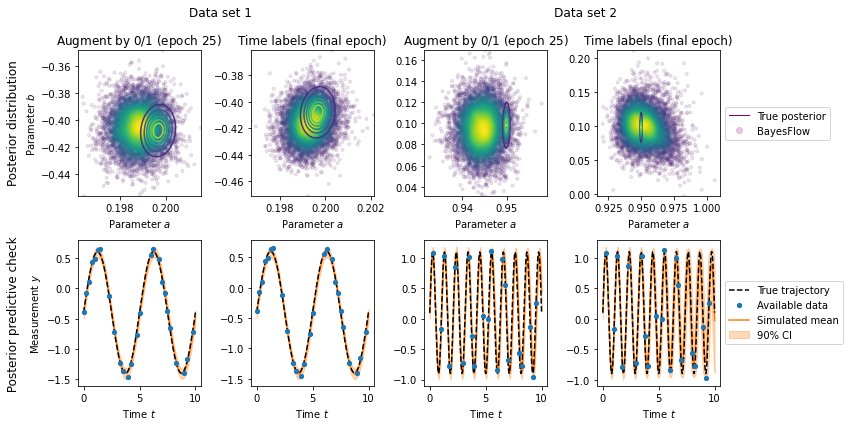

In [14]:
fig, axes_all = plt.subplots(2, 4, figsize=(12, 6))

axes = axes_all[0, :]
for result_ix, result in enumerate(results):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        posterior = posteriors[result_ix][amortizer_id]
        param_samples = samples[result_ix][amortizer_id]
        
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_posterior(ax, posterior, param_samples, amortizer_id, result_ix)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
            
# Legend
legend_elements = [
    Line2D([0], [0], color="purple", lw=1, label="True posterior"),
    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
]
axes[-1].legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

axes = axes_all[1, :]
for result_ix, (param_prior, result) in enumerate(zip(param_priors, results)):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        param_samples = samples[result_ix][amortizer_id]
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_predictive_check(ax, param_prior, result, param_samples)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
        ax.set_title(None)

# Legend
handles, labels = axes[-1].get_legend_handles_labels()
order = [2,3,0,1]
axes[-1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1,0.5))


fig.suptitle("Data set 1                                                                              Data set 2          ")
fig.supylabel(" Posterior predictive check             Posterior distribution       ")

fig.tight_layout()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Osc_augment_time_epoch25.{fmt}", dpi=300, bbox_inches='tight')